# War Exploratory Data Analysis

This project leverages a dataset on wars and their death tolls from 1989 to 2022 to perform exploratory data analysis, detecting trends, patterns and connections in the data.

In [278]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import random

## 1. Load and Preview the Data

In [280]:
countries_in_conflict = (
    "/Users/amanserhan/war_data_analysis/countries-in-conflict-data.csv"
)
war = pd.read_csv(countries_in_conflict)
war.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6970 entries, 0 to 6969
Data columns (total 4 columns):
 #   Column                                                                         Non-Null Count  Dtype 
---  ------                                                                         --------------  ----- 
 0   Entity                                                                         6970 non-null   object
 1   Code                                                                           6970 non-null   object
 2   Year                                                                           6970 non-null   int64 
 3   Deaths in ongoing conflicts in a country (best estimate) - Conflict type: all  6970 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 217.9+ KB


In [281]:
# Renaming two of the columns to be more concise
war = war.rename(
    {
        "Deaths in ongoing conflicts in a country (best estimate) - Conflict type: all": "Deaths",
        "Entity": "Country",
    },
    axis=1,
)
# Changing the data type of the country column to be categorical
war["Country"] = war["Country"].astype("category")
war.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6970 entries, 0 to 6969
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Country  6970 non-null   category
 1   Code     6970 non-null   object  
 2   Year     6970 non-null   int64   
 3   Deaths   6970 non-null   int64   
dtypes: category(1), int64(2), object(1)
memory usage: 186.8+ KB


## 2. Analysis and Modelling

Let's start by grouping our data by country and viewing some of descriptive statitics to inform the direction of the analysis.

In [284]:
by_country = war.groupby("Country", observed=False).agg(
    {"Deaths": ["sum", "max", "mean"]}
)
by_country.columns = ["Total", "Max in a Year", "Average"]
by_country = by_country.reset_index().sort_values(by="Total", ascending=False)
by_country.head(15)

,Country,Total,Max in a Year,Average
149,Rwanda,794913,772353,23379.794118
176,Syria,402416,76356,11835.764706
1,Afghanistan,315930,36370,9292.058824
61,Ethiopia,180528,102860,5309.647059
58,Eritrea,139749,50000,4110.264706
47,Democratic Republic of Congo,126691,33062,3726.205882
84,Iraq,126621,24492,3724.147059
115,Mexico,94150,18749,2769.117647
189,Ukraine,90924,82588,2674.235294
171,Sri Lanka,65337,10413,1921.676471


The first country in the dataframe, Rwanda, has a very high "Max in a Year" value. So maybe looking into standard deviation could provide interesting insights into the contrast between wars spread out over many years vs a few. Let's repeat the analysis in the previous cell, this time adding a standard deviation column.

In [286]:
by_country = war.groupby("Country", observed=False).agg(
    {"Deaths": ["sum", "max", "mean", "std"]}
)
by_country.columns = ["Total", "Max in a Year", "Average", "Standard Deviation"]
by_country = by_country.reset_index().sort_values(
    by="Standard Deviation", ascending=False
)
by_country.head(15)

,Country,Total,Max in a Year,Average,Standard Deviation
149,Rwanda,794913,772353,23379.794118,132348.667499
176,Syria,402416,76356,11835.764706,23437.716682
61,Ethiopia,180528,102860,5309.647059,17927.209739
189,Ukraine,90924,82588,2674.235294,14148.054251
58,Eritrea,139749,50000,4110.264706,12299.716738
1,Afghanistan,315930,36370,9292.058824,8794.458031
47,Democratic Republic of Congo,126691,33062,3726.205882,5986.041616
22,Bosnia and Herzegovina,65122,26840,1915.352941,5862.073653
84,Iraq,126621,24492,3724.147059,5468.181622
115,Mexico,94150,18749,2769.117647,5034.413611


Several the countries that have the highest death tolls also have high std deviation, suggesting a possible correlation between the duration of a conflict and its human cost. Let's plot the total death tolls against the std deviation to visualize the strength of this relationship. 

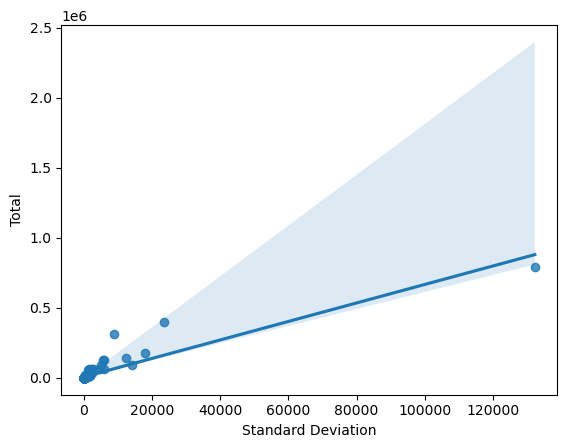

In [288]:
sns.regplot(x="Standard Deviation", y="Total", data=by_country)
plt.show()

There seem to be a few outliers in the total column, so let's identify those using the Interquartile Range 1.5 outlier method.

In [290]:
Q1_total = by_country["Total"].quantile(0.25)
Q3_total = by_country["Total"].quantile(0.75)
IQR_total = Q3_total - Q1_total

# Determining outlier bounds using the 1.5*IQR outlier rule
lower_bound_total = Q1_total - 1.5 * IQR_total
upper_bound_total = Q3_total + 1.5 * IQR_total

# Boolean mask for the non-outliers:
mask_total = (by_country["Total"] >= lower_bound_total) & (
    by_country["Total"] <= upper_bound_total
)

# New column setting outlier values to NaN
by_country["Total_Filtered"] = np.where(mask_total, by_country["Total"], np.nan)

by_country.head()

,Country,Total,Max in a Year,Average,Standard Deviation,Total_Filtered
149,Rwanda,794913,772353,23379.794118,132348.667499,NaN
176,Syria,402416,76356,11835.764706,23437.716682,NaN
61,Ethiopia,180528,102860,5309.647059,17927.209739,NaN
189,Ukraine,90924,82588,2674.235294,14148.054251,NaN
58,Eritrea,139749,50000,4110.264706,12299.716738,NaN


Now that we have filtered out the outliers, let's generate the same plot to see if there's a relationship between the standard deviations and the total deaths. Let's also calculate the Pearson Correlation Coefficient to evaluate the relationship numerically.

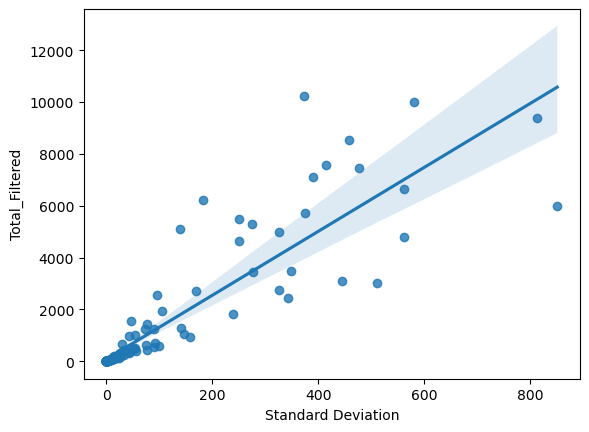

Pearson Correlation Coefficient: 0.8911557943408684


In [292]:
sns.regplot(x="Standard Deviation", y="Total_Filtered", data=by_country)
plt.show()

correlation = by_country[["Standard Deviation", "Total_Filtered"]].corr().iloc[0, 1]
print(f"Pearson Correlation Coefficient: {correlation}")

We can see a pretty strong positive relationship between standard deviation and the total death toll for each country, and so we can can conclude that countries that see a higher variability of death tolls across the years see a higher total and average death toll.

#### What trends / correlations can we observed between the number of deaths and the geographic regions of the countries in which they took place?
To do this analysis, we first need to have region information in our dataset, so let's import a country to region dataset and merge it with our main dataset.

In [295]:
country_region_data = "/Users/amanserhan/war_data_analysis/countries.csv"
country_region = pd.read_csv(country_region_data)
keep = ["name", "region", "subregion"]
country_region = country_region[keep]
country_region = country_region.rename(
    {"name": "Country", "region": "Region", "subregion": "Subregion"}, axis=1
)
country_region.head()

,Country,Region,Subregion
0,Afghanistan,Asia,Southern Asia
1,Aland Islands,Europe,Northern Europe
2,Albania,Europe,Southern Europe
3,Algeria,Africa,Northern Africa
4,American Samoa,Oceania,Polynesia


In [296]:
# Merging the country to region dataframe with the war dataframe
war_region = pd.merge(left=war, right=country_region, how="left", on="Country")
war_region.head()
war_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6970 entries, 0 to 6969
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Country    6970 non-null   object
 1   Code       6970 non-null   object
 2   Year       6970 non-null   int64 
 3   Deaths     6970 non-null   int64 
 4   Region     6426 non-null   object
 5   Subregion  6426 non-null   object
dtypes: int64(2), object(4)
memory usage: 326.8+ KB


In [297]:
missing_regions = war_region[war_region["Region"].isna()].drop_duplicates(
    subset="Country"
)
missing_regions.head()

,Country,Code,Year,Deaths,Region,Subregion
0,Abkhazia,OWID_ABK,1989,0,NaN,NaN
408,Bahamas,BHS,1989,0,NaN,NaN
1394,Cote d'Ivoire,CIV,1989,0,NaN,NaN
1530,Czechia,CZE,1989,0,NaN,NaN
1564,Czechoslovakia,OWID_CZS,1989,0,NaN,NaN


It looks like there are 5 countries missing region data. Let's manually fill that in.

In [299]:
# Generating the list of regions and subregions to ensure consistent naming for the missing values
regions_list = [country_region["Region"].drop_duplicates()]
subregion_list = [country_region["Subregion"].drop_duplicates()]
print(regions_list, "\n", subregion_list)

[0         Asia
1       Europe
3       Africa
4      Oceania
7     Americas
8        Polar
29         NaN
Name: Region, dtype: object] 
 [0                  Southern Asia
1                Northern Europe
2                Southern Europe
3                Northern Africa
4                      Polynesia
6                  Middle Africa
7                      Caribbean
8                            NaN
10                 South America
11                  Western Asia
13     Australia and New Zealand
14                Western Europe
19                Eastern Europe
21               Central America
22                Western Africa
23              Northern America
28               Southern Africa
31                Eastern Africa
32            South-Eastern Asia
44                  Eastern Asia
73                     Melanesia
89                    Micronesia
112                 Central Asia
Name: Subregion, dtype: object]


In [300]:
# Creating a merging a dataframe with the missing values filled in

manual_entries = {
    "Abkhazia": {"Region": "Europe", "Subregion": "Eastern Europe"},
    "Bahamas": {"Region": "Americas", "Subregion": "Caribbean"},
    "Cote d'Ivoire": {"Region": "Africa", "Subregion": "Western Africa"},
    "Czechia": {"Region": "Europe", "Subregion": "Eastern Europe"},
    "Czechoslovakia": {"Region": "Europe", "Subregion": "Eastern Europe"},
}
manual = pd.DataFrame(manual_entries).T.reset_index()
manual = manual.rename(
    {
        "index": "Country",
    },
    axis=1,
)

country_region = pd.merge(
    left=country_region,
    right=manual,
    on="Country",
    how="outer",
    suffixes=("", "_manual"),
)

print("Rows for Bahamas:\n", country_region.loc[country_region["Country"] == "Bahamas"])
print("Rows for Czechia:\n", country_region.loc[country_region["Country"] == "Czechia"])

Rows for Bahamas:
     Country Region Subregion Region_manual Subregion_manual
17  Bahamas    NaN       NaN      Americas        Caribbean
Rows for Czechia:
     Country Region Subregion Region_manual Subregion_manual
61  Czechia    NaN       NaN        Europe   Eastern Europe


In [301]:
# Fill NaN values in the original columns with the values from the manual columns
country_region["Region"] = country_region["Region"].combine_first(
    country_region["Region_manual"]
)
country_region["Subregion"] = country_region["Subregion"].combine_first(
    country_region["Subregion_manual"]
)
# Drop the temporary manual columns
country_region.drop(columns=["Region_manual", "Subregion_manual"], inplace=True)

In [302]:
# Test that the NaN values have been filled in
print("Rows for Bahamas:\n", country_region.loc[country_region["Country"] == "Bahamas"])
print("Rows for Czechia:\n", country_region.loc[country_region["Country"] == "Czechia"])

Rows for Bahamas:
     Country    Region  Subregion
17  Bahamas  Americas  Caribbean
Rows for Czechia:
     Country  Region       Subregion
61  Czechia  Europe  Eastern Europe


In [303]:
war_region = war_region = pd.merge(
    left=war, right=country_region, how="left", on="Country"
)
war_region.head(10)

,Country,Code,Year,Deaths,Region,Subregion
0,Abkhazia,OWID_ABK,1989,0,Europe,Eastern Europe
1,Abkhazia,OWID_ABK,1990,0,Europe,Eastern Europe
2,Abkhazia,OWID_ABK,1991,0,Europe,Eastern Europe
3,Abkhazia,OWID_ABK,1992,0,Europe,Eastern Europe
4,Abkhazia,OWID_ABK,1993,0,Europe,Eastern Europe
5,Abkhazia,OWID_ABK,1994,0,Europe,Eastern Europe
6,Abkhazia,OWID_ABK,1995,0,Europe,Eastern Europe
7,Abkhazia,OWID_ABK,1996,0,Europe,Eastern Europe
8,Abkhazia,OWID_ABK,1997,0,Europe,Eastern Europe
9,Abkhazia,OWID_ABK,1998,0,Europe,Eastern Europe


We're now ready to start analyzing. The first thing we'll look into is patterns over time, so let's do some time series analysis within each region and subregion. Let's start with graphing death tolls over time by region and see what trends we can visually pick up on. 

In [305]:
# Creating the grouped datafram for the graph 

by_region = war_region.groupby(["Region", "Year"], observed=False).agg(
    {"Deaths": ["sum", "mean"]}
)
by_region.columns = ["Total", "Average"]
by_region = by_region.reset_index()
by_region.head()

,Region,Year,Total,Average
0,Africa,1989,40879,771.301887
1,Africa,1990,72639,1370.547170
2,Africa,1991,33909,639.792453
3,Africa,1992,18368,346.566038
4,Africa,1993,31527,594.849057


No data for region: Polar


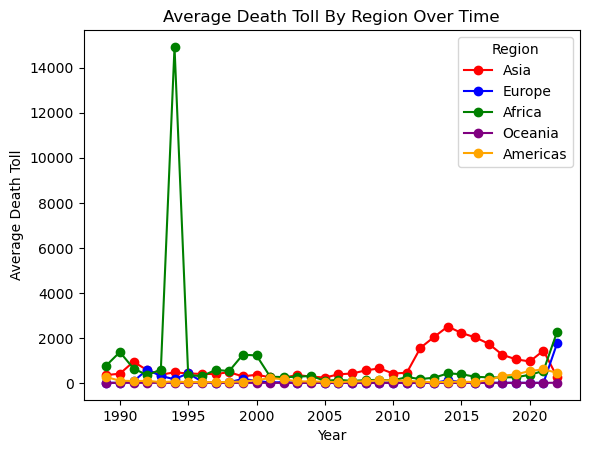

In [306]:
#Plotting average death toll over the years for each region: 
regions = ["Asia", "Europe", "Africa", "Oceania", "Americas", "Polar"]
colors_ = ["red","blue","green","purple","orange","yellow"]
fig, ax = plt.subplots()

for region, color in zip(regions, colors_):
    # Filter data for the current region
    region_data = by_region[by_region["Region"] == region]
    if region_data.empty:
        print(f"No data for region: {region}")
    else:
        # Plot the data with the specified color
        ax.plot(region_data["Year"], region_data["Average"], marker='o', label=region, color=color)

ax.legend(title='Region')
ax.set_title('Average Death Toll By Region Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Average Death Toll')
plt.show()

It seems like there's one year where Africa saw an extremely high average death toll, let's figure out at what year that was then exclude it from the graph so we can better see trends in the data.

In [308]:
outlier_list = by_region[(by_region['Region'] == 'Africa') & (by_region['Year'] < 1995)]
print(outlier_list)

   Region  Year   Total       Average
0  Africa  1989   40879    771.301887
1  Africa  1990   72639   1370.547170
2  Africa  1991   33909    639.792453
3  Africa  1992   18368    346.566038
4  Africa  1993   31527    594.849057
5  Africa  1994  790967  14923.905660


We know that the Rwanda genocide took place in 1994, where at least 800,000 people were killed. This can certainly help explain why the average is so high. Let's redo the plot, this time excluding this point so we can better observe any trends.

In [310]:
mask_1994 = (by_region["Region"]=="Africa") & (by_region['Year'] == 1994)
by_region_filtered = by_region[~mask_1994]
by_region_filtered.head(10)

,Region,Year,Total,Average
0,Africa,1989,40879,771.301887
1,Africa,1990,72639,1370.547170
2,Africa,1991,33909,639.792453
3,Africa,1992,18368,346.566038
4,Africa,1993,31527,594.849057
6,Africa,1995,19135,361.037736
7,Africa,1996,15462,291.735849
8,Africa,1997,30701,579.264151
9,Africa,1998,27949,527.339623
10,Africa,1999,66456,1253.886792


No data for region: Polar


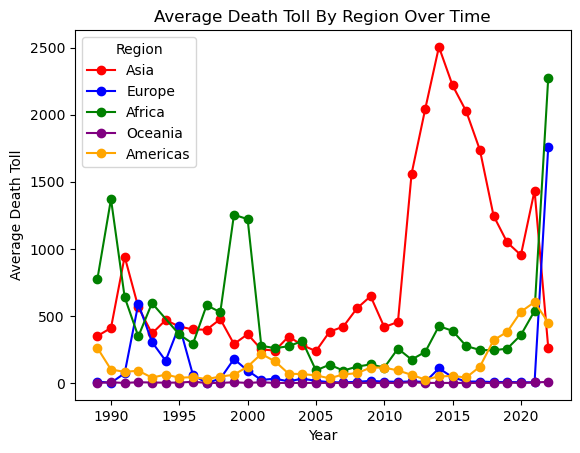

In [311]:
#Plotting average death toll over the years for each region, this time excluding the point for Africa in 1994.
regions = ["Asia", "Europe", "Africa", "Oceania", "Americas", "Polar"]
colors_ = ["red","blue","green","purple","orange","yellow"]
fig, ax = plt.subplots()

for region, color in zip(regions, colors_):
    # Filter data for the current region
    region_data = by_region_filtered[by_region_filtered["Region"] == region]
    if region_data.empty:
        print(f"No data for region: {region}")
    else:
        # Plot the data with the specified color
        ax.plot(region_data["Year"], region_data["Average"], marker='o', label=region, color=color)

ax.legend(title='Region')
ax.set_title('Average Death Toll By Region Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Average Death Toll')
plt.show()

As we can better see now, there's a lot of fluctuationin average deaths in each region, especially in Asia, Europe, and Africa. Some spikes consist of just one data point, which indicates that there were possible large conflicts in one or more countries in that region, which didn't last after that year. The fluctuation that caught my eye the most is the significant rise and fall of average death tolls in Asia from around 2010 to 2020. Let's investigate that further.
It looks like the fluctuation happened roughly between 2009 and 2018 (?) 
Let's confirm.

In [313]:
asia_mask = (by_region["Year"]>2008) & (by_region["Year"]<2022) & (by_region["Region"]=="Asia")
asia = by_region[asia_mask]
asia

,Region,Year,Total,Average
88,Asia,2009,29737,646.456522
89,Asia,2010,19158,416.478261
90,Asia,2011,20905,454.456522
91,Asia,2012,71774,1560.304348
92,Asia,2013,94001,2043.500000
93,Asia,2014,115234,2505.086957
94,Asia,2015,102028,2218.000000
95,Asia,2016,93116,2024.260870
96,Asia,2017,79868,1736.260870
97,Asia,2018,57322,1246.130435


It looks like our period of interest is from 2010 to 2020. We seem to have exhausted the insights we can get from grouping by regions, so let's investigate this trend from a subregion standpoint and see what we can observe.

In [315]:
# Creating a subregion dataframe for analysis

by_subregion = war_region.groupby(["Subregion", "Year"], observed=False).agg(
    {"Deaths": ["sum", "mean"],
    "Region": lambda x: x.iloc[0]
    }
)
by_subregion.columns = ["Total", "Average","Region"]
by_subregion = by_subregion.reset_index()
by_subregion.head()

,Subregion,Year,Total,Average,Region
0,Australia and New Zealand,1989,0,0.0,Oceania
1,Australia and New Zealand,1990,0,0.0,Oceania
2,Australia and New Zealand,1991,0,0.0,Oceania
3,Australia and New Zealand,1992,0,0.0,Oceania
4,Australia and New Zealand,1993,0,0.0,Oceania


In [316]:
# Creating a new dataframe, only with entries for Asia in our time period of interest
asia_mask2 = (by_subregion["Year"]>=2010) & (by_subregion["Year"]<=2020) & (by_subregion["Region"]=="Asia")
asia2 = by_subregion[asia_mask2]
asia2.head()

,Subregion,Year,Total,Average,Region
123,Central Asia,2010,121,24.2,Asia
124,Central Asia,2011,33,6.6,Asia
125,Central Asia,2012,0,0.0,Asia
126,Central Asia,2013,1,0.2,Asia
127,Central Asia,2014,0,0.0,Asia


Now let's generate another plot of average death toll vs year, but this time splitting the plots by subregion and only between 2010 and 2020 to see if there any trends of interest across the continent.

In [318]:
asia2['Subregion'].unique()

array(['Central Asia', 'Eastern Asia', 'South-Eastern Asia',
       'Southern Asia', 'Western Asia'], dtype=object)

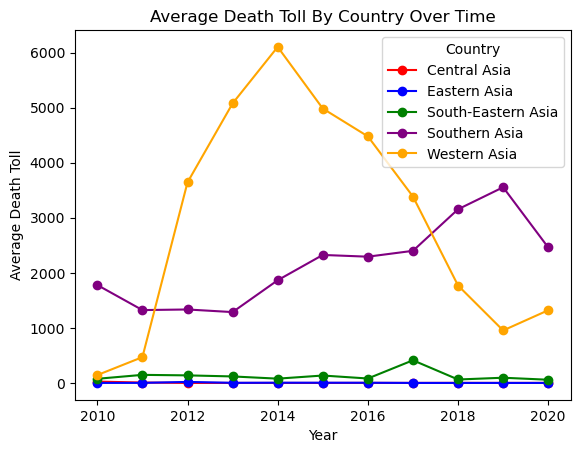

In [319]:
subregions = ['Central Asia', 'Eastern Asia', 'South-Eastern Asia', 'Southern Asia', 'Western Asia']
colors_ = ["red","blue","green","purple","orange"]
fig, ax = plt.subplots()

for subregion, color in zip(subregions, colors_):
    # Filter data for the current region
    subregion_data = asia2[asia2["Subregion"] == subregion]
    if subregion_data.empty:
        print(f"No data for subregion: {subregion}")
    else:
        # Plot the data with the specified color
        ax.plot(subregion_data["Year"], subregion_data["Average"], marker='o', label=subregion, color=color)

ax.legend(title='Country')
ax.set_title('Average Death Toll By Country Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Average Death Toll')
plt.show()

It looks like the subregion driving the fluctuation in the average death vs region graph was Western Asia. Western Asia encompasses 16 countries. Most Arab countries are in Western Asia. The beginning of our time period in question, 2011, was the start of the Arab Spring, which included mass uprisings across many Arab countries, largely revolting against corrupt leadership. The Arab Spring was also the catalyst for civil wars across some of these countries. Let's take one final step and see which country suffered the most death during the Arab Spring and subsequent wars. We'll essentially repeat the same analysis as before, this time looking at countries in West Asia

In [321]:
# Creating a new dataframe, only with entries for Western Asia in our time period of interest
west_asia_mask = (war_region["Year"]>=2010) & (war_region["Year"]<=2020) & (war_region["Subregion"]=="Western Asia")
west_asia = war_region[west_asia_mask]
print(west_asia.head())

     Country Code  Year  Deaths Region     Subregion
293  Armenia  ARM  2010       0   Asia  Western Asia
294  Armenia  ARM  2011       0   Asia  Western Asia
295  Armenia  ARM  2012       9   Asia  Western Asia
296  Armenia  ARM  2013       0   Asia  Western Asia
297  Armenia  ARM  2014       3   Asia  Western Asia


In [322]:
print(len(west_asia['Country'].unique()))
named_colors = list(mcolors.CSS4_COLORS.keys())

16


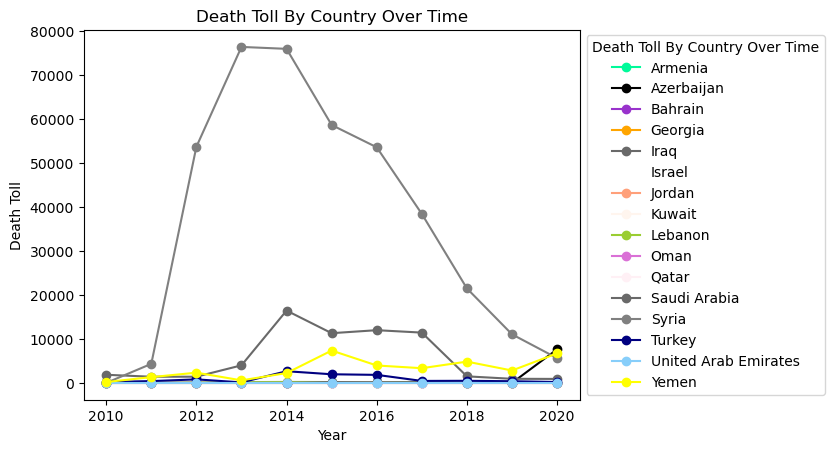

In [323]:
countries = west_asia['Country'].unique()
colors_ = random.sample(named_colors, 16)
fig, ax = plt.subplots()

for country, color in zip(countries, colors_):
    # Filter data for the current region
    country_data = west_asia[west_asia["Country"] == country]
    if country_data.empty:
        print(f"No data for countr: {country}")
    else:
        # Plot the data with the specified color
        ax.plot(country_data["Year"], country_data["Deaths"], marker='o', label=country, color=color)

ax.legend(title='Death Toll By Country Over Time', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Death Toll By Country Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Death Toll')
plt.show()

We can see that the driver behind the spike in death toll was Syria. The civil war in Syria began at the onset of the Arab Spring in 2011, and it is still ongoing today. We can see that 2012 to 2018 were particularly deadly years in Syria. We can also see that Iraq contributed to the spike from around 2014 to 2018. Even though US troops withdrew from Iraq in 2011 after their years-long war on the country, the effects of their offensive were and continue to be felt in the region. From 2014 to 2018, Iraq experienced attacks and exploitation at the the hands of terrorist groups like ISIS, contributing to the spike in the death toll in that time period. The proximity of Syria and Iraq is also often cited as a reason for the similarity in death toll trends in that time period.

#### Is there a correlation between the type of conflict and the death toll, and does that vary across regions / subregions?

In [326]:
#Read in and clean the data on types of conflict
by_type_file = "/Users/amanserhan/war_data_analysis/deaths-in-armed-conflicts-by-type.csv"
by_type = pd.read_csv(by_type_file)
by_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 8 columns):
 #   Column                                                                           Non-Null Count  Dtype 
---  ------                                                                           --------------  ----- 
 0   Entity                                                                           204 non-null    object
 1   Code                                                                             34 non-null     object
 2   Year                                                                             204 non-null    int64 
 3   Deaths in ongoing conflicts (best estimate) - Conflict type: one-sided violence  204 non-null    int64 
 4   Deaths in ongoing conflicts (best estimate) - Conflict type: non-state conflict  204 non-null    int64 
 5   Deaths in ongoing conflicts (best estimate) - Conflict type: extrasystemic       204 non-null    int64 
 6   Deaths in ongoing c

In [327]:
by_type = by_type.drop("Code",axis=1)
by_type = by_type.rename(
    {
       "Entity" : "Region",
        "Deaths in ongoing conflicts (best estimate) - Conflict type: one-sided violence": "One-Sided Violence",
        "Deaths in ongoing conflicts (best estimate) - Conflict type: non-state conflict": "Non-State Conflict",
        "Deaths in ongoing conflicts (best estimate) - Conflict type: extrasystemic": "Extrasystemic",
        "Deaths in ongoing conflicts (best estimate) - Conflict type: intrastate": "Intrastate",
        "Deaths in ongoing conflicts (best estimate) - Conflict type: interstate": "Interstate"
    },
axis = 1)
by_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Region              204 non-null    object
 1   Year                204 non-null    int64 
 2   One-Sided Violence  204 non-null    int64 
 3   Non-State Conflict  204 non-null    int64 
 4   Extrasystemic       204 non-null    int64 
 5   Intrastate          204 non-null    int64 
 6   Interstate          204 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 11.3+ KB


In [328]:
by_type_world = by_type[by_type["Region"] == "World"]
by_type_world = by_type_world.drop("Region",axis=1)
by_type_world.head()

,Year,One-Sided Violence,Non-State Conflict,Extrasystemic,Intrastate,Interstate
170,1989,7992,4170,0,53978,868
171,1990,9863,5251,0,79144,1086
172,1991,9739,3860,0,48449,21889
173,1992,11703,10459,0,53353,25
174,1993,10784,11905,0,44946,0


Let's start by plotting a stacked area chart to visualize the data better

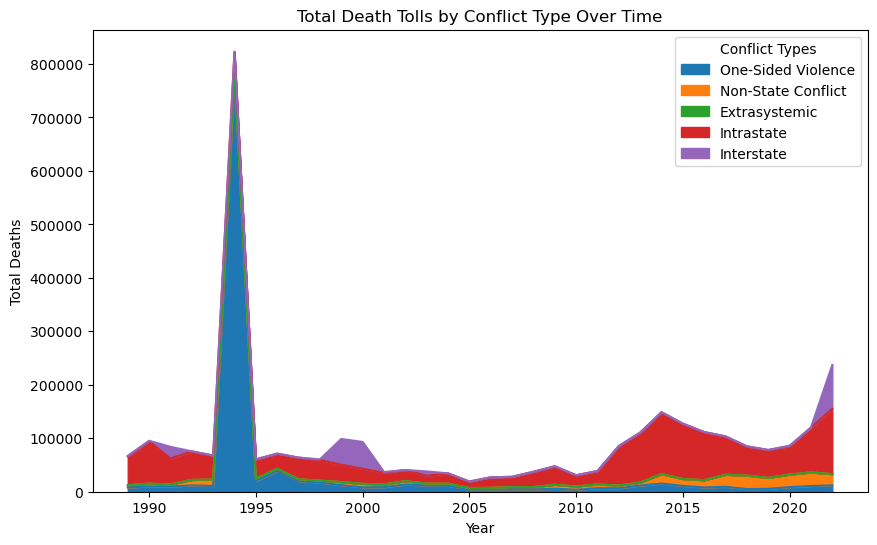

In [330]:
by_type_world.set_index('Year').plot.area(stacked=True, figsize=(10, 6))

plt.title('Total Death Tolls by Conflict Type Over Time')
plt.ylabel('Total Deaths')
plt.xlabel('Year')
plt.legend(title='Conflict Types')
plt.show()

Once again the Rwanda genocide of 1994 is significantly increasing the scale of the graph, so let's drop the 1994 data point to better observe the rest of the plot.

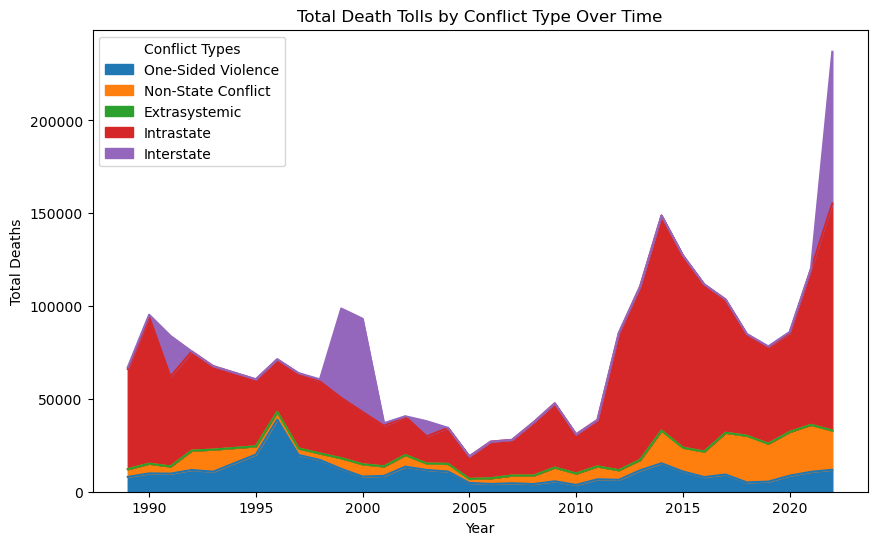

In [332]:
by_type_world=by_type_world[by_type_world['Year']=1994]

by_type_world.set_index('Year').plot.area(stacked=True, figsize=(10, 6))

plt.title('Total Death Tolls by Conflict Type Over Time')
plt.ylabel('Total Deaths')
plt.xlabel('Year')
plt.legend(title='Conflict Types')
plt.show()

It looks like instrastrate conflict is the most common type of conflic over time. Intrastate conflict is defined as "sustained political violence that takes place between armed groups representing the state, and one or more non-state groups. Violence of this sort usually is confined within the borders of a single state, but usually has significant international dimensions and holds the risk of spilling over into bordering states". The spike in intrastate conflct in the 2010s can likely be explained by the Syrian civil war and other conflicts proceeding the Arab Spring as discussed earlier. To confirm this and also look for new trends, let's replot this visual, this time broken down by region. 

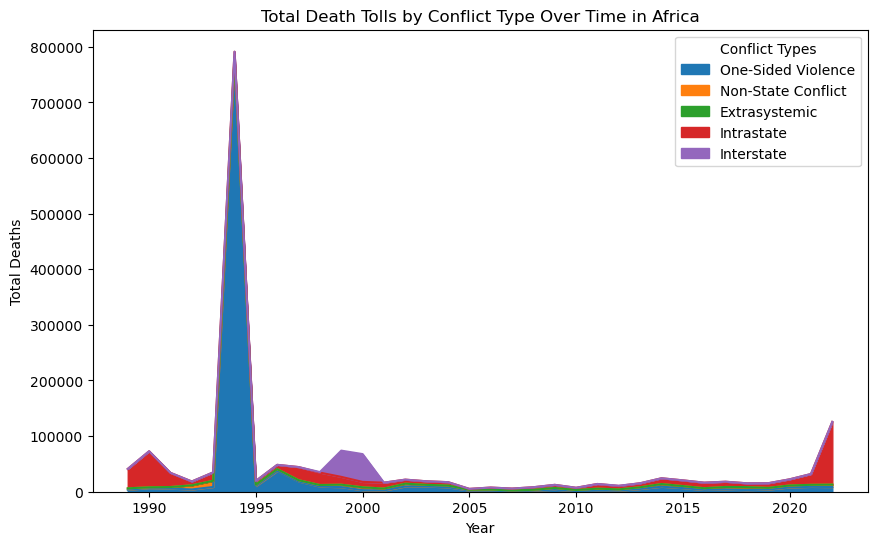

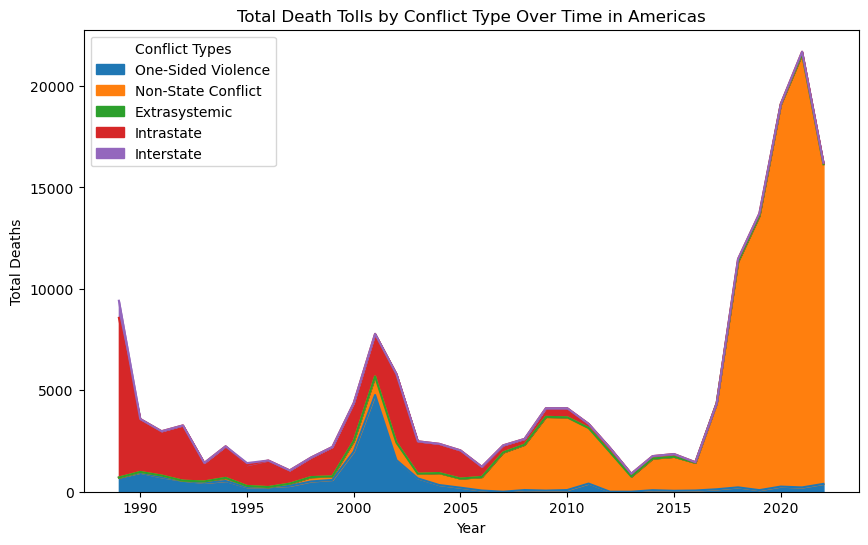

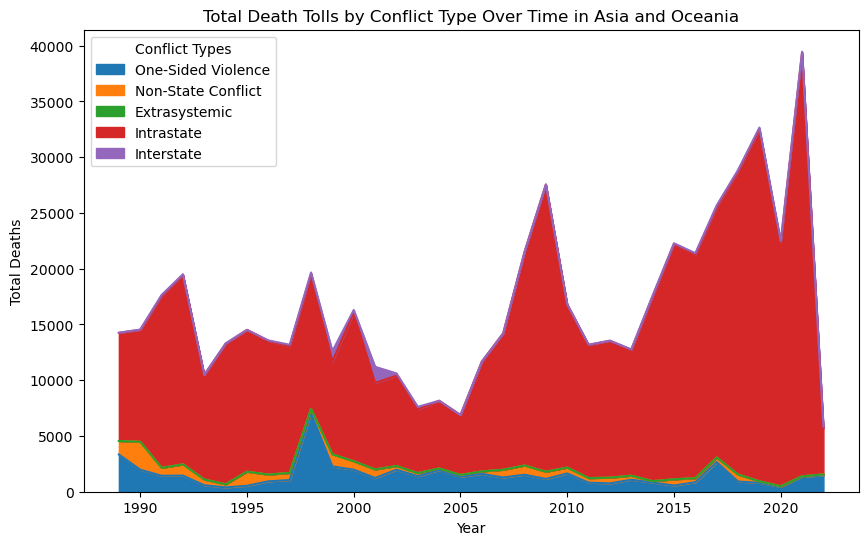

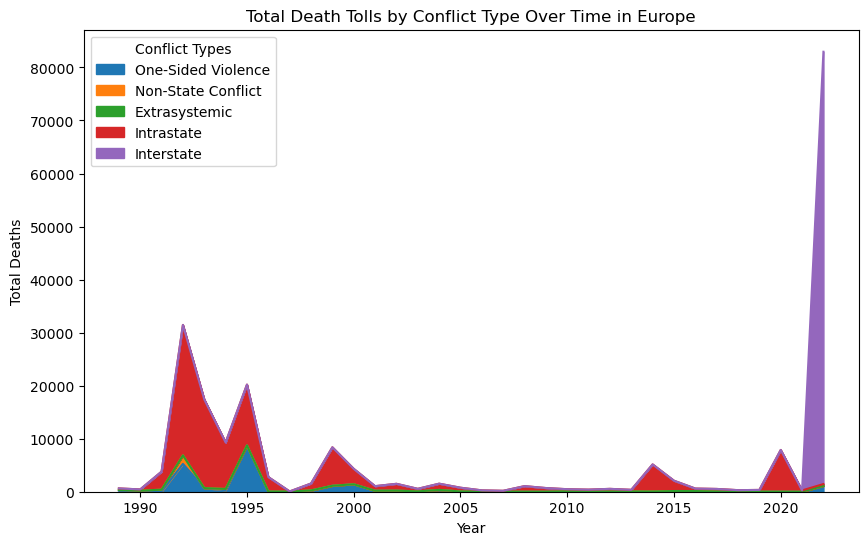

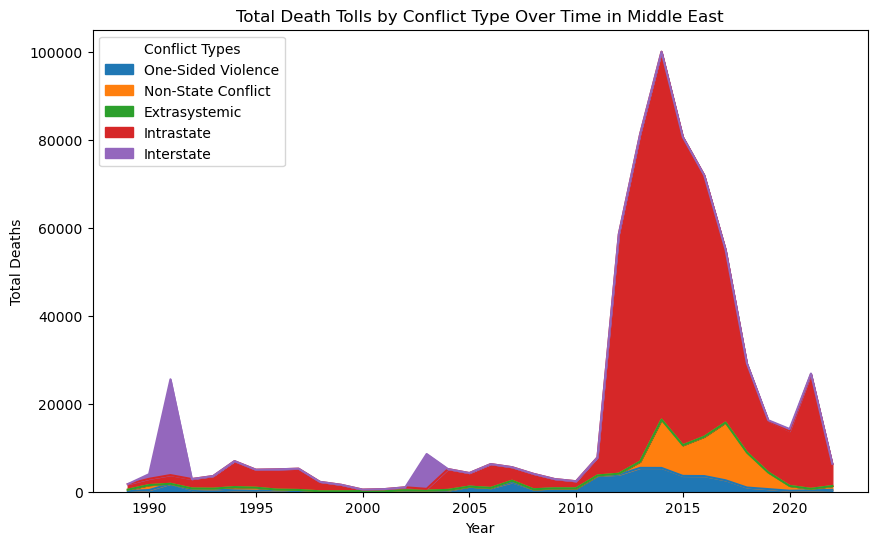

In [383]:
type_regions = ["Africa","Americas","Asia and Oceania","Europe","Middle East"]
for region in type_regions:
    region_df = by_type[by_type["Region"]==region]
    region_df.set_index('Year').plot.area(stacked=True, figsize=(10, 6))
    title = 'Total Death Tolls by Conflict Type Over Time in ' + region
    plt.title(title)
    plt.ylabel('Total Deaths')
    plt.xlabel('Year')
    plt.legend(title='Conflict Types')
    plt.show()

As expected, the death toll from intrastate conflict in the Middle East saw a large spike in the 2010s, coinciding with the Arab Spring and the onset of the Syrian civil war. However, instrastate conflict is not the most common type in all regions. Notably, in the Americas, non state conflict has been the most prevalent for the past decade. A non-state conflict is defined as "when at least two organized, armed groups, which do not belong to the country, use force resulting in at least 25 fatalities within one year." The spike in fatalities caused by non-state conflicts in the Americas in recent years would be interesting to investigate, but unfortunately, the data is not further broken down by subregion or country. Therefore, the best we can do is make conclusions general to the region and draw from the news to explain the spike.